<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/The-Hundred-Page-Machine-Learninng-Book/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
10/10 - 7s - 704ms/step - loss: 0.5911
Epoch 2/50
10/10 - 0s - 14ms/step - loss: 0.5909
Epoch 3/50
10/10 - 0s - 13ms/step - loss: 0.5910
Epoch 4/50
10/10 - 0s - 14ms/step - loss: 0.5908
Epoch 5/50
10/10 - 0s - 11ms/step - loss: 0.5907
Epoch 6/50
10/10 - 0s - 12ms/step - loss: 0.5907
Epoch 7/50
10/10 - 0s - 14ms/step - loss: 0.5908
Epoch 8/50
10/10 - 0s - 13ms/step - loss: 0.5907
Epoch 9/50
10/10 - 0s - 16ms/step - loss: 0.5907
Epoch 10/50
10/10 - 0s - 11ms/step - loss: 0.5907
Epoch 11/50
10/10 - 0s - 14ms/step - loss: 0.5910
Epoch 12/50
10/10 - 0s - 13ms/step - loss: 0.5907
Epoch 13/50
10/10 - 0s - 16ms/step - loss: 0.5907
Epoch 14/50
10/10 - 0s - 13ms/step - loss: 0.5907
Epoch 15/50
10/10 - 0s - 13ms/step - loss: 0.5907
Epoch 16/50
10/10 - 0s - 11ms/step - loss: 0.5907
Epoch 17/50
10/10 - 0s - 14ms/step - loss: 0.5907
Epoch 18/50
10/10 - 0s - 11ms/step - loss: 0.5909
Epoch 19/50
10/10 - 0s - 11ms/step - loss: 0.5907
Epoch 20/50
10/10 - 0s - 15ms/step - loss: 0.5908
Epoch 21

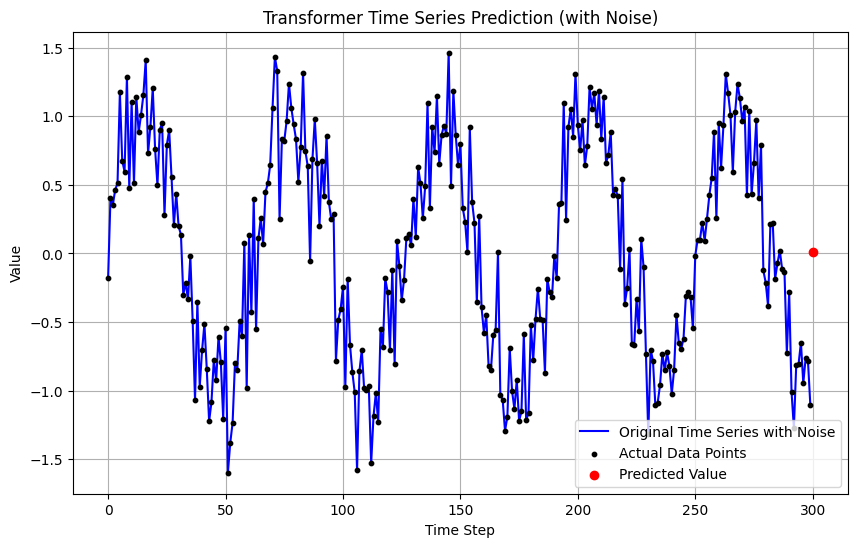

예측값: [[0.00846425]]


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, Embedding
import matplotlib.pyplot as plt

# 1. 데이터 준비 (사인 함수 + 노이즈 추가)
def create_time_series(n_steps):
    # 사인 함수 + 가우시안 노이즈 추가
    noise = 0.3 * np.random.randn(n_steps)  # 표준 편차 0.3의 가우시안 노이즈 추가
    return np.sin(np.arange(n_steps) * 0.1) + noise

n_steps = 300  # 데이터 포인트 300개
time_series = create_time_series(n_steps)

# 시계열 데이터를 RNN과 유사하게 [samples, time steps, features] 형태로 변환
X = []
y = []
time_step = 10  # 한 번에 10 스텝을 입력으로 사용
for i in range(len(time_series) - time_step):
    X.append(time_series[i:i + time_step])
    y.append(time_series[i + time_step])

X = np.array(X)
y = np.array(y)

# 2. 트랜스포머 모델 구축

# 포지셔널 인코딩 함수 (시간 정보를 추가하기 위해 사용)
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] * np.arange(d_model)[np.newaxis, :] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :]//2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# 트랜스포머 블록 구성
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed forward part
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)

    x = LayerNormalization(epsilon=1e-6)(x + x_ff)
    return x

# 입력 크기 설정
input_shape = (time_step, 1)
inputs = Input(shape=input_shape)

# 포지셔널 인코딩 추가
pos_encoding = positional_encoding(time_step, input_shape[-1])
x = inputs + pos_encoding

# 트랜스포머 인코더 블록 추가
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

# 출력 레이어 추가 (단일 출력 예측)
outputs = Dense(1)(x[:, -1])

# 모델 구성
model = Model(inputs, outputs)

# 3. 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 4. 모델 학습
model.fit(X, y, epochs=50, batch_size=32, verbose=2)

# 5. 테스트 데이터로 예측
test_input = time_series[-time_step:].reshape((1, time_step, 1))  # 마지막 10개 값을 테스트로 사용
predicted = model.predict(test_input)

# 6. 예측 결과 시각화
plt.figure(figsize=(10, 6))

# 원래의 시계열 데이터 (사인 함수 + 노이즈)
plt.plot(np.arange(n_steps), time_series, label='Original Time Series with Noise', color='blue')

# 산점도 추가: 실제 데이터 포인트
plt.scatter(np.arange(n_steps), time_series, color='black', s=10, label='Actual Data Points', zorder=3)

# 예측값을 시각화: 마지막 10개 이후의 예측값을 한 점으로 표시
plt.scatter(n_steps, predicted, color='red', label='Predicted Value', zorder=5)

plt.title("Transformer Time Series Prediction (with Noise)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.show()

print(f"예측값: {predicted}")
